In [1]:
from dotenv import load_dotenv
import re
load_dotenv()

import os
import requests

os.environ["TAVILY_API_KEY"]=os.getenv("TAVILY_API_KEY")
os.environ["GROQ_API_KEY"] = os.getenv("GROQ_API_KEY")
os.environ['HF_TOKEN']=os.getenv("HF_TOKEN")

In [2]:
from langchain_groq import ChatGroq
from langchain_community.tools import ArxivQueryRun,WikipediaQueryRun
# from langchain_community.utilities import WikipediaAPIWrapper,ArxivAPIWrapper
from langchain_community.utilities.arxiv import ArxivAPIWrapper
from langchain.schema.document import Document
from langchain_huggingface import HuggingFaceEmbeddings
from langchain_groq import ChatGroq
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.chains.combine_documents import create_stuff_documents_chain
from langchain_core.prompts import ChatPromptTemplate
from langchain.chains.retrieval import create_retrieval_chain
from langchain_community.vectorstores import FAISS
from langchain_community.document_loaders import PyPDFDirectoryLoader

os.environ["HF_TOKEN"] = os.getenv("HF_TOKEN")

llm=ChatGroq(model="llama-3.3-70b-versatile")
embedding = HuggingFaceEmbeddings(model_name="all-MiniLM-L6-v2")

e:\END_END\venv1\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [21]:
# arxiv_wrapper = ArxivAPIWrapper(top_k_results=5,doc_content_chars_max=10000)
# arxiv= ArxivQueryRun(api_wrapper=arxiv_wrapper,description="Query arxiv paper, more than 1 paper")
# arxiv_wrapper = ArxivAPIWrapper(top_k_results=5)
# arxiv= ArxivQueryRun(api_wrapper=arxiv_wrapper)
# arxiv = ArxivAPIWrapper(top_k_results=5, doc_content_chars_max=1000)

In [22]:
# query = "Transformer architecture in NLP"
# docs = arxiv.load_all_available_meta(query)
# docs
# print(type(docs))        # Should be <class 'list'>
# # print(type(docs[0]))     # Should be <class 'langchain_core.documents.base.Document'>
# print(docs[0].metadata) 


In [3]:
from langchain_community.document_loaders import ArxivLoader

# arxiv = ArxivLoader(
#     query="large language models OR llm applications OR natural language processing OR artificial intelligence models"
# )

# docs = arxiv.get_summaries_as_docs()
# docs
# # print(docs[0].page_content[:100])
# # print(docs[0].metadata["Entry ID"])

In [4]:
from typing_extensions import TypedDict,Optional
from langchain_core.messages import AnyMessage,HumanMessage, SystemMessage, AIMessage, BaseMessage ## Human message or AI message
from typing import Annotated  ## labelling
from langgraph.graph.message import add_messages  ## Reducers in Langgraph

In [5]:
class State(TypedDict):
    # messages: Annotated[list[AnyMessage], add_messages]
    messages: Annotated[list[AnyMessage], add_messages]
    summary: Optional[str]
    research_ideas: Optional[str]
    critique: Optional[str]
    experiment_plan: Optional[str]
    final_report: Optional[str]
    verdict: Optional[str]

In [6]:
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition

In [7]:
def topic_gen(state:State):
    user_prompt = state["messages"][-1].content

    # system_prompt = (
    #     "You are a research assistant. Extract a concise research query or keywords "
    #     "suitable for finding academic papers from the following user input."
    # )
#     system_prompt = (
#     "You are a research assistant. Given the user's research interest, respond ONLY with a concise search query "
#     "that can be used to look up academic papers (e.g., on arXiv). Do NOT explain or wrap it in quotes. "
#     "Just return the raw search string."
# )
    system_prompt = (
        "You are a research assistant. Based on the user's interest, return a single-line search query using OR operators "
        "between 2–5 keywords/phrases, without explanations. This query will be used for searching arXiv."
    )



    prompt = [
        SystemMessage(content=system_prompt),
        HumanMessage(content=user_prompt)
    ]

    response = llm.invoke(prompt)

    cleaned_response = response.content.strip().replace('"', '')

    response.content = cleaned_response
    return {
        "messages": state["messages"] + [response]
    }

In [8]:
def arxiv_search(state:State):
    last_message = state["messages"][-1]

    if last_message.type != "ai":
        raise ValueError("Expected last message to be from assistant (the generated query).")

    query = last_message.content.strip()
    print("🔍 Using query for arXiv search:", query)

    arxiv = ArxivLoader(
    query=query
    )

    results = arxiv.get_summaries_as_docs()  # returns List[Document]

    if isinstance(results, str):
        raise TypeError("arxiv.run() returned a string instead of Document objects.")

    if not isinstance(results, list):
        results = [results]

    os.makedirs("downloaded_papers", exist_ok=True)
    downloaded_files = []

    for i, doc in enumerate(results):
        metadata = doc.metadata
        pdf_url = re.sub(r'abs', 'pdf', metadata.get("Entry ID"))
        title = metadata.get("title", f"paper_{i+1}")
        safe_title = title.replace(" ", "_").replace("/", "_")[:50]
        filepath = f"downloaded_papers/{safe_title}.pdf"

        if pdf_url:
            try:
                response = requests.get(pdf_url)
                if response.status_code == 200:
                    with open(filepath, "wb") as f:
                        f.write(response.content)
                    print(f"✅ Downloaded: {filepath}")
                    downloaded_files.append(filepath)
                else:
                    print(f"❌ Failed to download {pdf_url}")
            except Exception as e:
                print(f"⚠️ Error downloading {pdf_url}: {e}")
        else:
            print(f"⚠️ No PDF URL found for {title}")

    return {
        "messages": state["messages"],
        "downloaded_papers": downloaded_files
    }


In [9]:
def summarizer(state:State):

    prompt= ChatPromptTemplate.from_template(
    
    """
    You are a helpful research assistant. Given the following academic paper(s) from vector store, summarize the key findings and contributions of each one in bullet points.
    Format the summary clearly with headings if multiple papers are involved.
    <context>
    {context}
    </context>
    Question:{input}

    """
    )
    loader=PyPDFDirectoryLoader("downloaded_papers")
    documents = loader.load()
    text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000,chunk_overlap=200)
    final_documents = text_splitter.split_documents(documents)
    vectors = FAISS.from_documents(final_documents,embedding)

    doc_chain = create_stuff_documents_chain(llm,prompt)
    retriever = vectors.as_retriever()
    retriever_chain = create_retrieval_chain(retriever,doc_chain)
    response = retriever_chain.invoke({"input": "Summarize the papers."})

    return {
        "messages": state["messages"] + [AIMessage(content=response["answer"])],
        "summary": response["answer"]
    }

In [10]:
def idea_synthesizer(state: State):
    summary = state.get("summary", "")
    if not summary:
        raise ValueError("Summary not found in state. Ensure summarizer node ran correctly.")

    system_prompt = (
        "You are a research scientist. Based on the following summary of academic papers, generate 3–5 original research ideas. "
        "These should be novel, feasible, and build upon the existing work. Return them as bullet points."
    )

    prompt = [
        SystemMessage(content=system_prompt),
        HumanMessage(content=summary)
    ]

    response = llm.invoke(prompt)

    return {
        "messages": state["messages"] + [response],
        "research_ideas": response.content
    }


In [21]:
def critic_agent(state: State):
    ideas = state.get("research_ideas", "")
    verdict="proceed"
    if not ideas:
        raise ValueError("Research ideas not found in state.")

    system_prompt = (
        "You are an expert research reviewer. Analyze the following research ideas based on three criteria: "
        "1) Feasibility, 2) Novelty, and 3) Potential impact. Provide detailed feedback on each idea. "
        "At the end, summarize whether the overall set of ideas is 'promising' or 'needs revision'."
    )

    prompt = [
        SystemMessage(content=system_prompt),
        HumanMessage(content=ideas)
    ]

    response = llm.invoke(prompt)

    critique_text = response.content
    if "needs revision" in critique_text.lower():
        verdict = "revise"
    else:
        verdict = "proceed"

    return {
        "messages": state["messages"] + [response],
        "critique": critique_text,
        "verdict": verdict
    }


In [22]:
def experiment_designer(state: State):
    critiques = state.get("critique", "")
    ideas = state.get("research_ideas", "")

    if not ideas or not critiques:
        raise ValueError("Missing research ideas or critiques. Ensure previous nodes ran successfully.")

    system_prompt = (
        "You are a senior AI researcher. Based on the following research ideas and their critique, "
        "design a basic experimental plan for the most promising idea. "
        "Include details like objective, dataset (real or synthetic), method, metrics, and expected outcome."
    )

    full_input = f"Research Ideas:\n{ideas}\n\nCritiques:\n{critiques}"

    prompt = [
        SystemMessage(content=system_prompt),
        HumanMessage(content=full_input)
    ]

    response = llm.invoke(prompt)

    return {
        "messages": state["messages"] + [response],
        "experiment_plan": response.content
    }


In [23]:
def report_generator(state: State):
    summary = state.get("summary", "")
    ideas = state.get("research_ideas", "")
    critiques = state.get("critique", "")
    experiment_plan = state.get("experiment_plan", "")

    if not (summary and ideas and critiques and experiment_plan):
        raise ValueError("Some components are missing. Ensure all previous nodes completed successfully.")

    system_prompt = (
        "You are an AI research assistant. Based on the provided research pipeline components, "
        "generate a clean, professional markdown-formatted report."
    )

    user_input = f"""
# 📚 Literature Summary
{summary}

# 💡 Research Ideas
{ideas}

# 🧪 Critique of Ideas
{critiques}

# 🧬 Experiment Plan
{experiment_plan}
"""

    prompt = [
        SystemMessage(content=system_prompt),
        HumanMessage(content=user_input)
    ]

    response = llm.invoke(prompt)

    return {
        "messages": state["messages"] + [response],
        "final_report": response.content
    }


In [24]:
def condition_node(state:State):
    verdict = state.get("verdict","proceed")
    if verdict=="proceed":
        return "Exp-Plan"
    return "Idea"

In [25]:
builder = StateGraph(State)
builder.add_node("Topic Generation",topic_gen)
builder.add_node("ARXIV",arxiv_search)
builder.add_node("Summarizer",summarizer)
builder.add_node("Idea",idea_synthesizer)
builder.add_node("Critic",critic_agent)
builder.add_node("Exp-Plan",experiment_designer)
builder.add_node("Final-Report",report_generator)

In [26]:
builder.add_edge(START,"Topic Generation")
builder.add_edge("Topic Generation","ARXIV")
builder.add_edge("ARXIV","Summarizer")
builder.add_edge("Summarizer","Idea")
builder.add_edge("Idea","Critic")
# builder.add_conditional_edges(
#     "Critic",
#     condition=lambda state: state.get("verdict", "proceed"),
#     path_map={
#         "proceed": "Exp-Plan",
#         "revise": "Idea"  # or loop back to "Idea", or any recovery node
#     }
# )
builder.add_conditional_edges("Critic",condition_node)
builder.add_edge("Exp-Plan","Final-Report")
builder.add_edge("Final-Report",END)

In [27]:
graph = builder.compile()

In [28]:
messages=graph.invoke({"messages":"I want to research in the area of Agentic-AI"})
messages
for m in messages['messages']:
    m.pretty_print()

🔍 Using query for arXiv search: Agentic AI OR Autonomous Agents OR Artificial General Intelligence OR Cognitive Architectures
✅ Downloaded: downloaded_papers/paper_1.pdf
✅ Downloaded: downloaded_papers/paper_2.pdf
✅ Downloaded: downloaded_papers/paper_3.pdf
================================ Human Message =================================

I want to research in the area of Agentic-AI
================================== Ai Message ==================================

Agentic AI OR Autonomous Agents OR Artificial General Intelligence OR Cognitive Architectures
================================== Ai Message ==================================

## Paper Summaries
There are multiple papers mentioned in the context, but they are not explicitly provided. However, based on the references and context, I will summarize the key findings and contributions of each relevant paper.

### Task Force Report: The Role of Autonomy in DoD Systems [80]
* The report explores the role of autonomy in Department of D

In [28]:
messages["research_ideas"]

'Here are 3-5 original research ideas based on the provided summary of academic papers:\n\n* **Investigating the Impact of Cultural Context on High-Dimensional Human Value Representation in LLMs**: This research idea builds upon the work presented in Paper 1 and explores how cultural context influences the representation of human values in large language models. By training and evaluating LLMs on datasets from diverse cultural backgrounds, researchers can gain insights into the nuances of human value representation and develop more culturally sensitive models.\n* **Developing Instruction-Tuned LLMs for Low-Resource Languages**: Inspired by the introduction of Cendol in Paper 2, this research idea involves creating instruction-tuned generative large language models for low-resource languages. By leveraging transfer learning and fine-tuning techniques, researchers can adapt existing models to support languages with limited datasets and resources, promoting linguistic diversity and inclus

In [60]:
messages["final_report"]

'# Literature Summary\n## Paper Summaries\nThe provided context includes a collection of references and excerpts from various academic papers related to Large Language Models (LLMs), taxonomies, and their applications. The key findings and contributions of each paper are summarized below:\n\n* **SIGDIAL 2023 Paper**: Presents a taxonomy for LLM applications, focusing on the skills dimension, which captures the types of LLM capabilities utilized in various applications.\n* **IEEE Access 2024 Paper**: Discusses the applications, taxonomies, open issues, and challenges related to LLMs, providing a comprehensive overview of the current state of LLM research and its applications.\n* **Perspectives in Business Informatics Research 2023 Paper**: Introduces the concept of a "Morphological Box" for AI solutions, which involves evaluating and refining AI solutions using a taxonomy development method.\n* **TELeR: A General Taxonomy of LLM Prompts Paper**: Presents a general taxonomy of LLM prompt

In [29]:
from IPython.display import Image,display

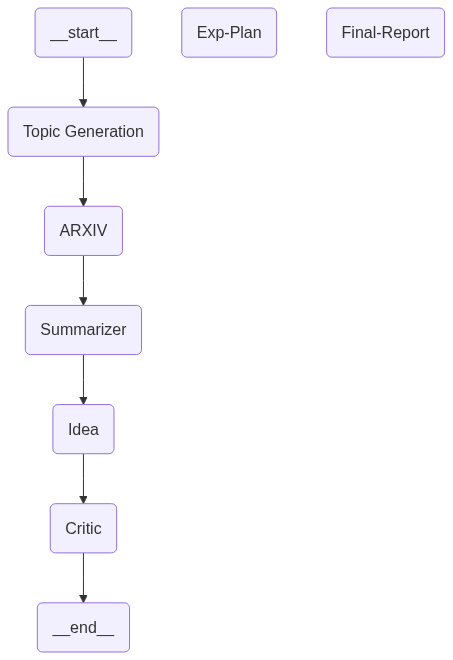

In [31]:
display(Image(graph.get_graph().draw_mermaid_png()))